In [ ]:
!pip install optuna
!pip install mplfinance
import numpy as np
import pandas as pd
import math as mt
import datetime as dt
import optuna as opt
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Thu thập dữ liệu

## Dữ liệu của Microsoft

In [ ]:
#Tải dữ liệu cổ phiếu của Microsoft trong 5 năm
microsoft_data = yf.download('MSFT', start='2020-01-01', end='2024-11-30')
#In thông tin dữ liệu
microsoft_data.info()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1237 entries, 2020-01-02 to 2024-11-29
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, MSFT)  1237 non-null   float64
 1   (Close, MSFT)      1237 non-null   float64
 2   (High, MSFT)       1237 non-null   float64
 3   (Low, MSFT)        1237 non-null   float64
 4   (Open, MSFT)       1237 non-null   float64
 5   (Volume, MSFT)     1237 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 67.6 KB


In [ ]:
#In các dòng dữ liệu
microsoft_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,,
2020-01-02,153.938217,160.619995,160.729996,158.330002,158.779999,22622100
2020-01-03,152.021393,158.619995,159.949997,158.059998,158.320007,21116200
2020-01-06,152.414352,159.029999,159.100006,156.509995,157.080002,20813700
2020-01-07,151.024704,157.580002,159.669998,157.320007,159.320007,21634100
2020-01-08,153.430252,160.089996,160.800003,157.949997,158.929993,27746500


In [ ]:
#Kiểm tra dữ liệu thiếu, dữ liệu trống, dữ liệu trùng lặp
print("Dữ liệu thiếu: ", microsoft_data.isnull().values.sum())
print("Dữ liệu trống: ", microsoft_data.isna().values.any())
print("Dữ liệu trùng lặp: ", microsoft_data.duplicated().values.sum())

Dữ liệu thiếu:  0
Dữ liệu trống:  False
Dữ liệu trùng lặp:  0


##Dữ liệu 5 công ty

In [ ]:
#Gán mã cổ phiếu
tickers = ['MSFT', 'ORCL', 'IBM', 'CRM', 'SAP']
#Tải dữ liệu cổ phiếu của 5 công ty trong 5 năm
data = yf.download(tickers, start='2020-01-01', end='2024-11-30', group_by='ticker')
#In thông tin dữ liệu
data.info()

[*********************100%***********************]  5 of 5 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1237 entries, 2020-01-02 to 2024-11-29
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (MSFT, Open)       1237 non-null   float64
 1   (MSFT, High)       1237 non-null   float64
 2   (MSFT, Low)        1237 non-null   float64
 3   (MSFT, Close)      1237 non-null   float64
 4   (MSFT, Adj Close)  1237 non-null   float64
 5   (MSFT, Volume)     1237 non-null   int64  
 6   (IBM, Open)        1237 non-null   float64
 7   (IBM, High)        1237 non-null   float64
 8   (IBM, Low)         1237 non-null   float64
 9   (IBM, Close)       1237 non-null   float64
 10  (IBM, Adj Close)   1237 non-null   float64
 11  (IBM, Volume)      1237 non-null   int64  
 12  (CRM, Open)        1237 non-null   float64
 13  (CRM, High)        1237 non-null   float64
 14  (CRM, Low)         1237 non-null   float64
 15  (CRM, Close)       1237 non-null   float64
 16  (CRM, 

In [ ]:
#In các dòng dữ liệu
data.head()

Ticker            MSFT                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2020-01-02  158.779999  160.729996  158.330002  160.619995  153.938217   
2020-01-03  158.320007  159.949997  158.059998  158.619995  152.021393   
2020-01-06  157.080002  159.100006  156.509995  159.029999  152.414352   
2020-01-07  159.320007  159.669998  157.320007  157.580002  151.024704   
2020-01-08  158.929993  160.800003  157.949997  160.089996  153.430252   

Ticker                       IBM                                      ...  \
Price         Volume        Open        High         Low       Close  ...   
Date                                                                  ...   
2020-01-02  22622100  129.063095  129.942642  128.843216  129.464630  ...   
2020-01-03  21116200  127.695984  128.929260  127.686424  128.432129  ...   
2020-01-06  20813700  127.552582  128.336517  127.342255  128.202682  ...   
2020-01-07  21634100  127.810707  129.024857  127.533463  128.288712  ...   
2020-01-08  27746500  128.594650  129.885284  128.030594  129.359467  ...   

Ticker           ORCL                                         SAP              \
Price             Low      Close  Adj Close    Volume        Open        High   
Date                                                                            
2020-01-02  53.230000  53.950001  49.943474  13899600  135.419998  137.139999   
2020-01-03  52.950001  53.759998  49.767582  11026700  133.300003  134.919998   
2020-01-06  53.349998  54.040001  50.026787  10982400  133.160004  134.220001   
2020-01-07  53.610001  54.160000  50.137878  12015400  134.080002  134.350006   
2020-01-08  53.700001  54.130001  50.333145  11856700  133.899994  135.520004   

Ticker                                                   
Price              Low       Close   Adj Close   Volume  
Date                                                     
2020-01-02  135.399994  136.809998  125.219994  2967500  
2020-01-03  133.300003  133.979996  122.629738   507800  
2020-01-06  133.130005  134.199997  122.831108   442900  
2020-01-07  133.440002  133.619995  122.300240   621200  
2020-01-08  133.759995  135.080002  123.636559   513300  

[5 rows x 30 columns]

In [ ]:
#Kiểm tra dữ liệu thiếu, dữ liệu trống, dữ liệu trùng lặp
print("Dữ liệu thiếu: ", data.isnull().values.sum())
print("Dữ liệu trống: ", data.isna().values.any())
print("Dữ liệu trùng lặp: ", data.duplicated().values.sum())

Dữ liệu thiếu:  0
Dữ liệu trống:  False
Dữ liệu trùng lặp:  0


#Thống kê mô tả
- Câu hỏi thống kê
1. Giá cổ phiếu cao/thấp nhất là bao nhiêu?
2. Giá cổ phiếu trung bình mỗi năm là bao nhiêu?
3. Trong các quý giá cổ phiếu trung bình là bao nhiêu?
4. Lượng cổ phiếu giao dịch mỗi năm là bao nhiêu?
5. Tỷ suất lợi nhuận theo ngày của công ty trong năm 2024 giao động trong khoảng nào?

In [ ]:
#Các tham số thống kê
microsoft_data.aggregate(['min', 'max', 'mean', 'median', 'std'])

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT
min,130.141022,135.419998,140.570007,132.520004,137.009995,9.200800e+06
max,466.718781,467.559998,468.350006,464.459991,467.000000,9.701270e+07
mean,287.131638,291.875295,294.706047,288.778528,291.808714,2.876825e+07
median,276.049591,281.779999,285.920013,278.720001,282.100006,2.568110e+07
std,80.466445,78.556309,78.779099,78.243294,78.647755,1.272732e+07


##Giá đóng

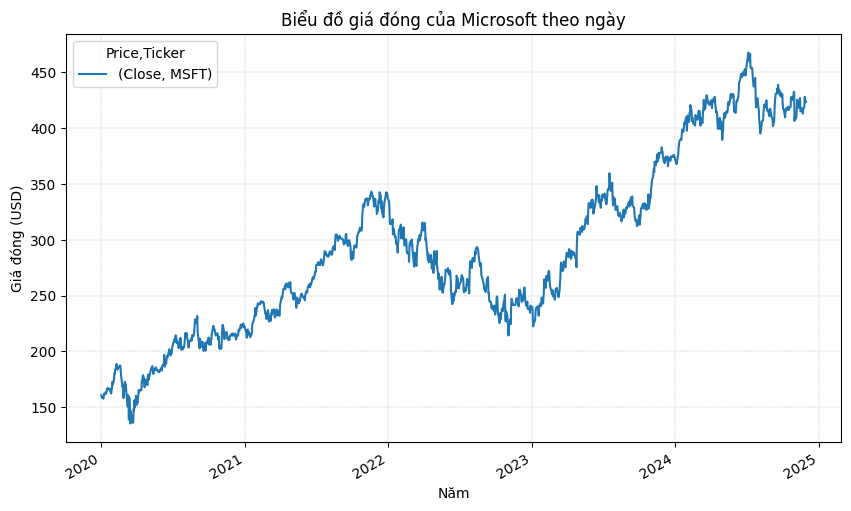

In [ ]:
#Biểu đồ giá đóng theo ngày
microsoft_close = microsoft_data[['Close']]
microsoft_close.plot(figsize=(10, 6), subplots=False, title="Biểu đồ giá đóng của Microsoft theo ngày", xlabel="Năm", ylabel="Giá đóng (USD)")
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.show()

In [ ]:
# Tạo cột 'Year' từ chỉ số ngày
microsoft_data['Year'] = microsoft_data.index.year
# Tính trung bình giá đóng (Close) mỗi năm
average_close_by_year = microsoft_data.groupby('Year')['Close'].mean()
# In kết quả
average_close_by_year

Price,Close
Ticker,MSFT
Year,
2020,193.026126
2021,275.940754
2022,268.917091
2023,313.951001
2024,418.576277


<Figure size 1000x800 with 0 Axes>

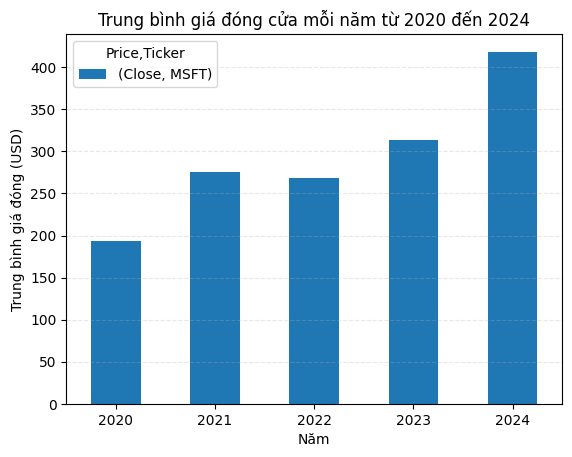

In [ ]:
# Vẽ biểu đồ cột
plt.figure(figsize=(10, 8))
average_close_by_year.plot(kind='bar')
plt.title('Trung bình giá đóng cửa mỗi năm từ 2020 đến 2024')
plt.xlabel('Năm')
plt.ylabel('Trung bình giá đóng (USD)')
plt.xticks(rotation=0)
plt.yticks()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

In [ ]:
microsoft_close = microsoft_data[['Close']].copy()
microsoft_close['Date'] = microsoft_close.index
microsoft_close['Date'] = pd.to_datetime(microsoft_close['Date'])


# Thêm cột 'Year' và 'Quarter' từ cột 'Date'
microsoft_close['Year'] = microsoft_close['Date'].dt.year
microsoft_close['Quarter'] = microsoft_close['Date'].dt.quarter
microsoft_close = microsoft_close[~((microsoft_close['Year'] == 2024) & (microsoft_close['Quarter'] == 4))]

# Tính trung bình giá đóng cửa theo từng năm và từng quý
avg_close_by_quarter = microsoft_close.groupby(['Year', 'Quarter'])['Close'].mean()

# Chuyển đổi dữ liệu sang dạng bảng với hàng là quý và cột là năm
avg_close_pivot = avg_close_by_quarter.unstack(level=0)
avg_close_pivot.index.name = 'Quarter'
avg_close_pivot.columns.name = 'Year'
avg_close_pivot.index = [f"Q{q}" for q in avg_close_pivot.index]

# In kết quả
print("Trung bình giá đóng cửa theo từng quý (2020-2024):")
avg_close_pivot

Trung bình giá đóng cửa theo từng quý (2020-2024):


Price        Close                                                
Ticker        MSFT                                                
Year          2020        2021        2022        2023        2024
Q1      164.449032  232.021475  300.853871  255.079840  404.821639
Q2      181.524921  254.182379  271.403225  313.408064  422.319524
Q3      210.033437  290.950313  264.049374  330.442857  427.465623
Q4      215.024375  324.210157  239.985555  355.930161         NaN

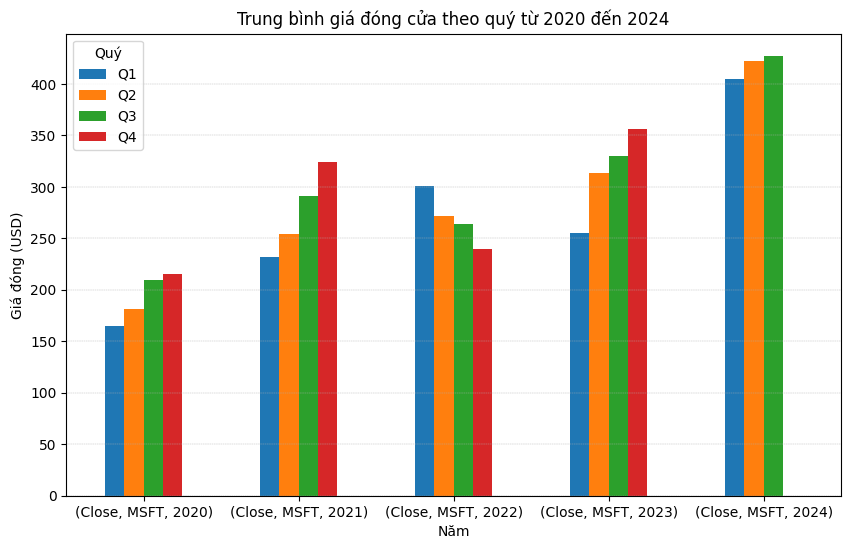

In [ ]:
# Chuyển đổi dữ liệu để hàng là năm và cột là quý
avg_close_pivot_transposed = avg_close_pivot.T
# Vẽ biểu đồ cột
avg_close_pivot_transposed.plot(kind='bar', figsize=(10, 6))
plt.title("Trung bình giá đóng cửa theo quý từ 2020 đến 2024")
plt.xlabel("Năm")
plt.ylabel("Giá đóng (USD)")
plt.xticks(rotation=0)
plt.yticks()
plt.legend(title="Quý", fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.3)
plt.show()


##Lượng cổ phiếu giao dịch

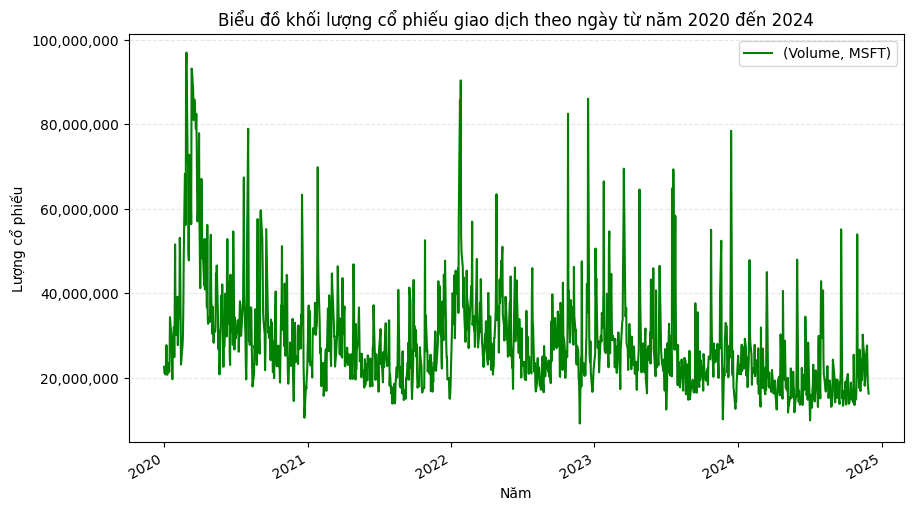

In [ ]:
microsoft_volume = microsoft_data[['Volume']]
microsoft_volume.plot(figsize=(10, 6), subplots=False, color='Green')
plt.ticklabel_format(style='plain', axis='y')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.title('Biểu đồ khối lượng cổ phiếu giao dịch theo ngày từ năm 2020 đến 2024')
plt.xlabel('Năm')
plt.ylabel('Lượng cổ phiếu')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

In [ ]:
# Tạo cột "Year" từ index để nhóm theo năm
microsoft_data['Year'] = microsoft_data.index.year

# Tính tổng khối lượng giao dịch (Volume) theo từng năm
volume_by_year = microsoft_data.groupby('Year')['Volume'].sum()

# In bảng thống kê
print("Bảng thống kê lượng cổ phiếu bán ra mỗi năm:")
volume_by_year

Bảng thống kê lượng cổ phiếu bán ra mỗi năm:


Price,Volume
Ticker,MSFT
Year,
2020,9527876900
2021,6555279200
2022,7836049700
2023,6918889900
2024,4748229900


<Figure size 1600x800 with 0 Axes>

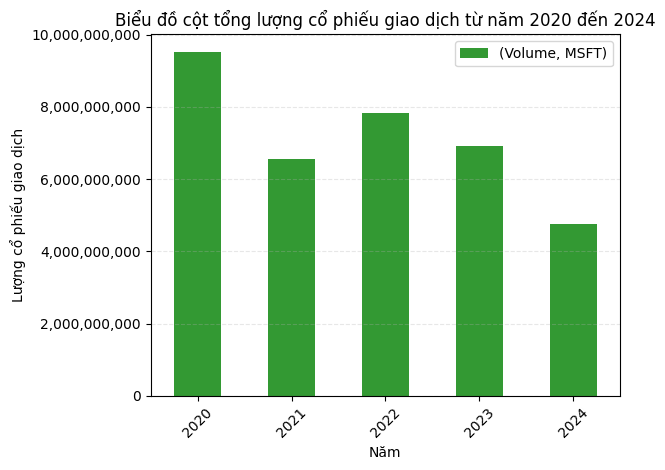

In [ ]:
plt.figure(figsize=(16, 8))
volume_by_year.plot(kind='bar', alpha=0.8, color='Green')
plt.title('Biểu đồ cột tổng lượng cổ phiếu giao dịch từ năm 2020 đến 2024')
plt.ylabel('Lượng cổ phiếu giao dịch')
plt.xlabel('Năm')
plt.ticklabel_format(style='plain', axis='y')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
microsoft_volume = microsoft_data[['Volume']].copy()
microsoft_volume['Date'] = microsoft_volume.index
microsoft_volume['Date'] = pd.to_datetime(microsoft_volume['Date'])


# Thêm cột 'Year' và 'Quarter' từ cột 'Date'
microsoft_volume['Year'] = microsoft_volume['Date'].dt.year
microsoft_volume['Quarter'] = microsoft_volume['Date'].dt.quarter
microsoft_volume = microsoft_volume[~((microsoft_volume['Year'] == 2024) & (microsoft_volume['Quarter'] == 4))]

# Tính tổng lượng giao dịch theo từng năm và từng quý
sum_volume_by_quarter = microsoft_volume.groupby(['Year', 'Quarter'])['Volume'].sum()

# Chuyển đổi dữ liệu sang dạng bảng với hàng là quý và cột là năm
sum_volume_pivot = sum_volume_by_quarter.unstack(level=0)
sum_volume_pivot.index.name = 'Quarter'
sum_volume_pivot.columns.name = 'Year'
sum_volume_pivot.index = [f"Q{q}" for q in sum_volume_pivot.index]

# In kết quả
print("tổng lượng giao dịch theo từng quý (2022-2024):")
sum_volume_pivot

tổng lượng giao dịch theo từng quý (2022-2024):


Price         Volume                                                        
Ticker          MSFT                                                        
Year            2020          2021          2022          2023          2024
Q1      3.058748e+09  1.863984e+09  2.378916e+09  2.029304e+09  1.398925e+09
Q2      2.438515e+09  1.572319e+09  1.991618e+09  1.699893e+09  1.196949e+09
Q3      2.230791e+09  1.466900e+09  1.587636e+09  1.562902e+09  1.269289e+09
Q4      1.799823e+09  1.652076e+09  1.877880e+09  1.626791e+09           NaN

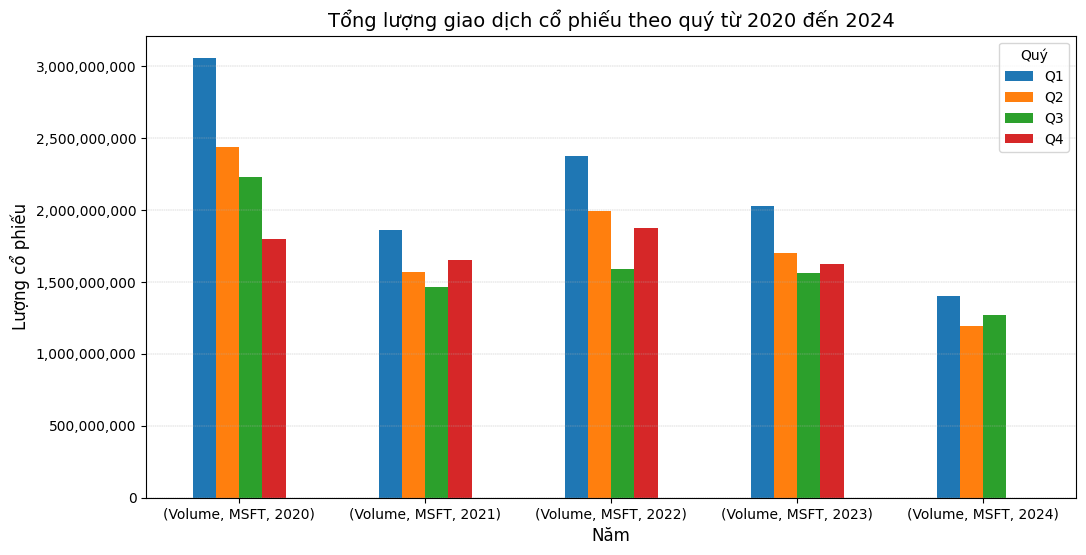

In [ ]:
# Chuyển đổi dữ liệu để hàng là năm và cột là quý
sum_volume_pivot_transposed = sum_volume_pivot.T
# Vẽ biểu đồ cột
sum_volume_pivot_transposed.plot(kind='bar', figsize=(12, 6))
plt.title("Tổng lượng giao dịch cổ phiếu theo quý từ 2020 đến 2024", fontsize=14)
plt.xlabel("Năm", fontsize=12)
plt.ylabel("Lượng cổ phiếu", fontsize=12)
plt.xticks(rotation=0)
plt.ticklabel_format(style='plain', axis='y')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.legend(title="Quý", fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.3)
plt.show()

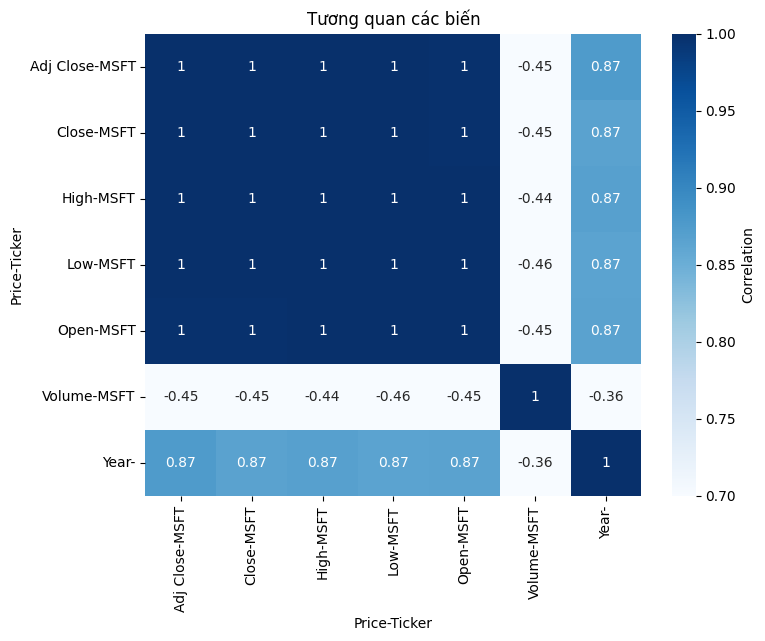

In [ ]:
correlation_microsoft = microsoft_data.corr()
# Vẽ biểu đồ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_microsoft, annot=True, cmap='Blues', vmin=0.7, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title("Tương quan các biến")
plt.show()

##Tỷ suất lợi nhuận

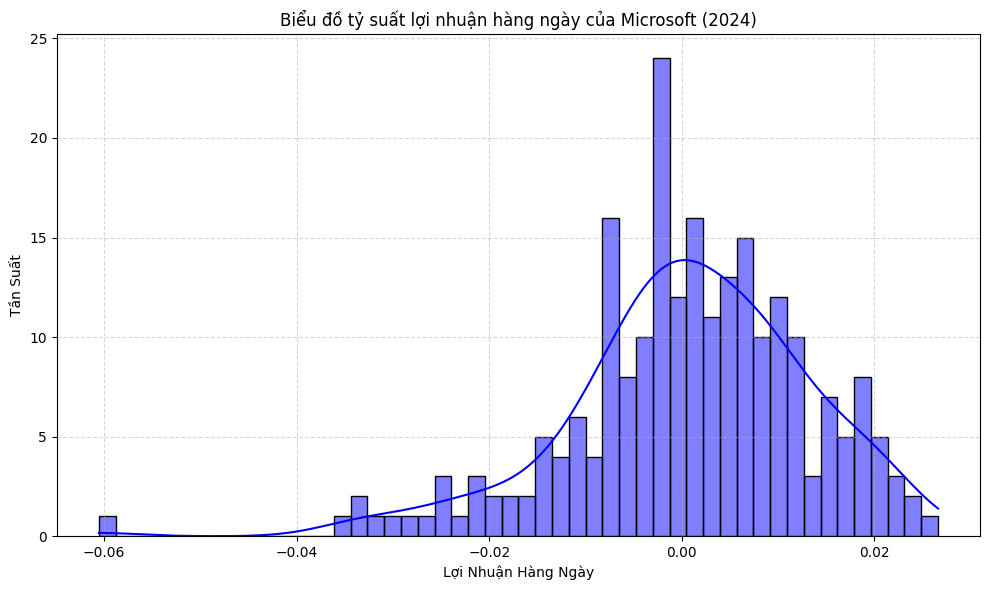

In [ ]:
#Biểu đồ tỷ xuất lợi nhuận của Microsoft
microsoft_data['Daily Returns'] = microsoft_data['Close'].pct_change()

# Lọc dữ liệu lợi nhuận hàng ngày trong năm 2024
daily_returns_2024 = microsoft_data['Daily Returns']['2024-01-01':'2024-11-30']

# Vẽ biểu đồ phân phối lợi nhuận hàng ngày với đường cong mật độ
plt.figure(figsize=(10, 6))
sns.histplot(
    daily_returns_2024.dropna(),
    bins=50,
    kde=True,
    color="blue")
plt.title("Biểu đồ tỷ suất lợi nhuận hàng ngày của Microsoft (2024)")
plt.xlabel("Lợi Nhuận Hàng Ngày")
plt.ylabel("Tần Suất")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

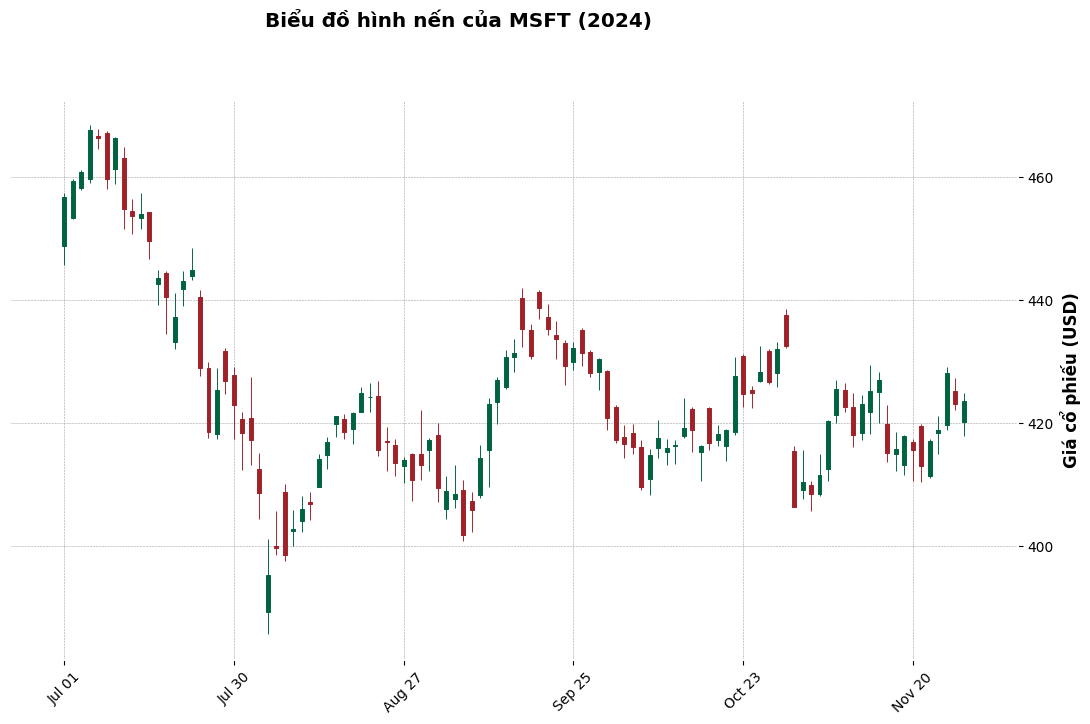

In [ ]:
# Chuẩn bị dữ liệu cho biểu đồ hình nến
ohlc_data = {ticker: data[ticker][['Open', 'High', 'Low', 'Close', 'Volume']] for ticker in tickers}

# Chọn cổ phiếu muốn vẽ (ví dụ: 'MSFT')
ticker_to_plot = 'MSFT'

# Lấy dữ liệu của cổ phiếu được chọn
candlestick_data = ohlc_data[ticker_to_plot]

# Lọc dữ liệu chỉ trong năm 2024
candlestick_data.index = pd.to_datetime(candlestick_data.index)  # Đảm bảo cột index là kiểu datetime
candlestick_data_2024 = candlestick_data.loc['2024']

# Nếu vẫn quá nhiều nến, giới hạn trong Q1 (quý 1 năm 2024)
candlestick_data_2024_Q1 = candlestick_data_2024.loc['2024-07-01':'2024-11-30']

# Vẽ biểu đồ hình nến (loại bỏ volume và đường MA)
mpf.plot(
    candlestick_data_2024_Q1,
    type='candle',                # Loại biểu đồ: hình nến
    style='charles',              # Kiểu dáng biểu đồ
    title=f"Biểu đồ hình nến của {ticker_to_plot} (2024)",  # Tiêu đề
    ylabel='Giá cổ phiếu (USD)',  # Nhãn trục y
    figsize=(14, 8)               # Kích thước biểu đồ
)

#So sánh 5 công ty trong ngành

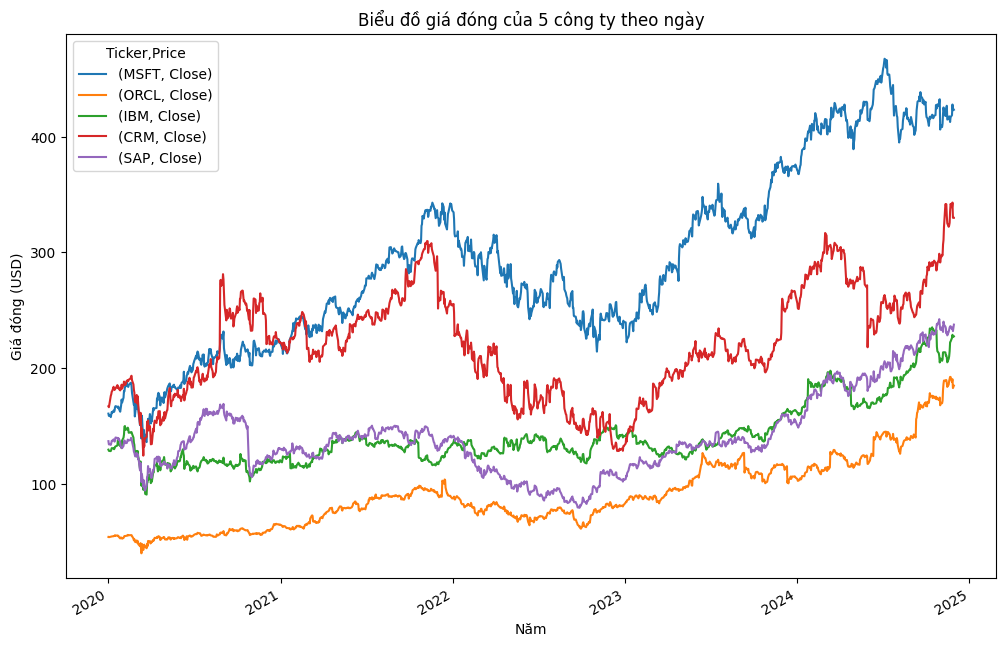

In [ ]:
#Biểu đồ giá đóng hàng ngày trong 5 năm
data_close = data.loc[:, (slice(None), ['Close'])]
data_close.plot(figsize=(12, 8), subplots=False, title="Biểu đồ giá đóng của 5 công ty theo ngày", xlabel="Năm", ylabel="Giá đóng (USD)")
plt.show()

In [ ]:
average_closer = pd.DataFrame()

for ticker in tickers:
    # Thêm cột 'Year' vào DataFrame của từng công ty
    data.loc[:, (ticker, 'Year')] = data[ticker].index.year

    # Tính trung bình giá đóng theo năm
    yearly_avg = data[ticker].groupby('Year')['Close'].mean()
    average_closer[ticker] = yearly_avg

print("Bảng trung bình giá đóng theo năm cho từng công ty:")
average_closer.style.background_gradient(cmap='Blues', axis=1)

Bảng trung bình giá đóng theo năm cho từng công ty:


,MSFT,ORCL,IBM,CRM,SAP
Year,,,,,
2020,193.026126,55.268696,118.929519,200.865297,134.416798
2021,275.940754,81.519683,128.959140,247.365317,137.822658
2022,268.917091,75.828685,133.637689,176.666534,102.357012
2023,313.951001,104.060720,139.118280,203.995200,132.630360
2024,418.576277,137.484069,190.907273,277.023203,200.492251


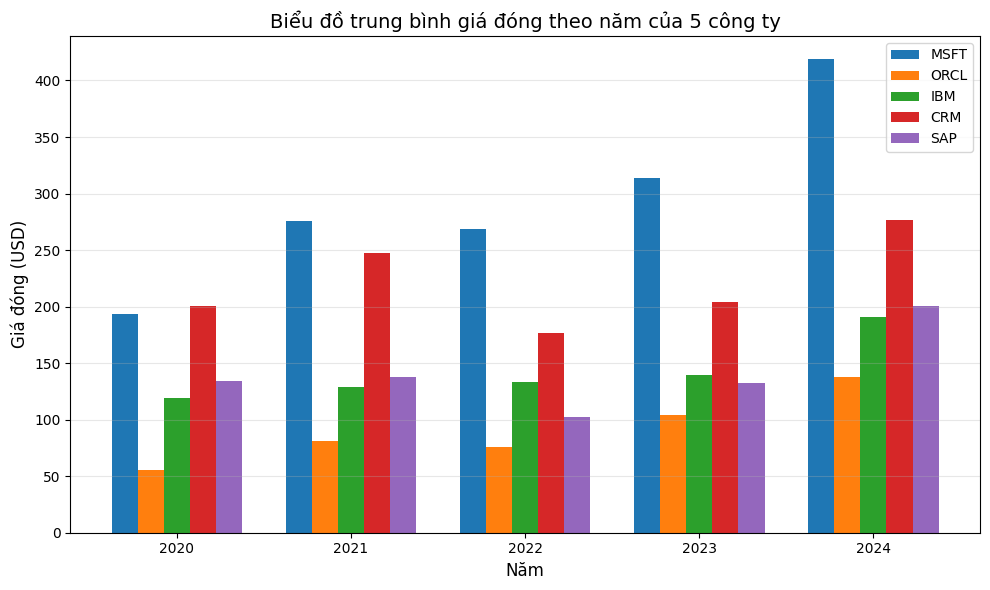

In [ ]:
# Vẽ biểu đồ cột nhóm
plt.figure(figsize=(10, 6))

# Xác định số lượng năm
years = average_closer.index
bar_width = 0.15
x = range(len(years))

# Vẽ từng nhóm cột
for i, company in enumerate(average_closer.columns):
    plt.bar([pos + i * bar_width for pos in x], average_closer[company],
            width=bar_width, label=company)

# Thêm nhãn và tiêu đề
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Giá đóng (USD)', fontsize=12)
plt.title('Biểu đồ trung bình giá đóng theo năm của 5 công ty', fontsize=14)
plt.xticks([pos + 2 * bar_width for pos in x], years)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

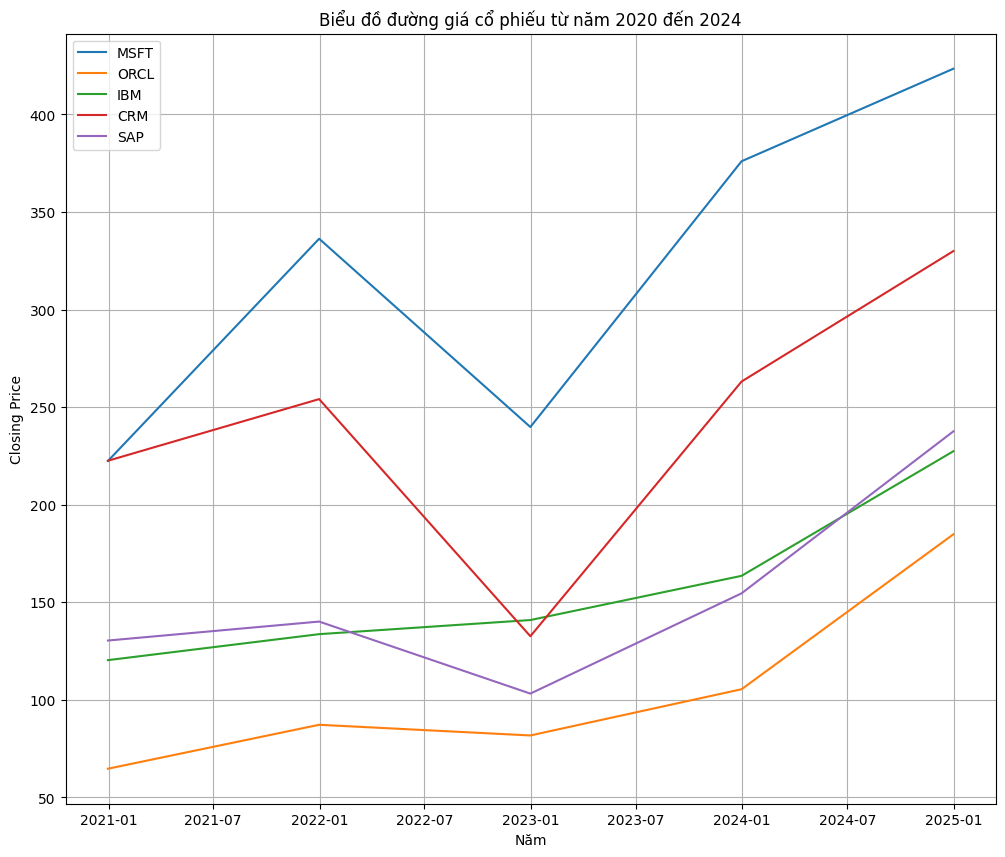

In [ ]:
plt.figure(figsize=(12, 10))

for ticker in tickers:
    data_year = data[(ticker, 'Close')].resample('YE').last()
    plt.plot(data_year, label=ticker)

plt.title('Biểu đồ đường giá cổ phiếu từ năm 2020 đến 2024')
plt.xlabel('Năm')
plt.ylabel('Closing Price')
plt.grid(True)
plt.legend()
plt.show()

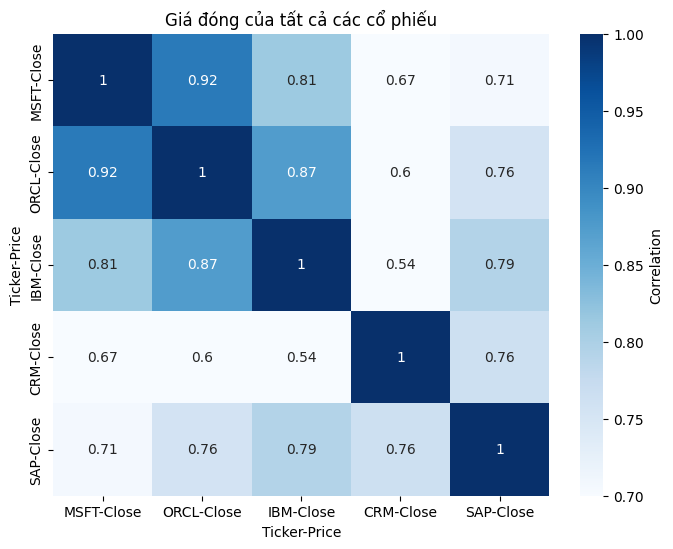

In [ ]:
correlation_matrix = data_close.corr()

# Vẽ biểu đồ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', vmin=0.7, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title("Giá đóng của tất cả các cổ phiếu")
plt.show()

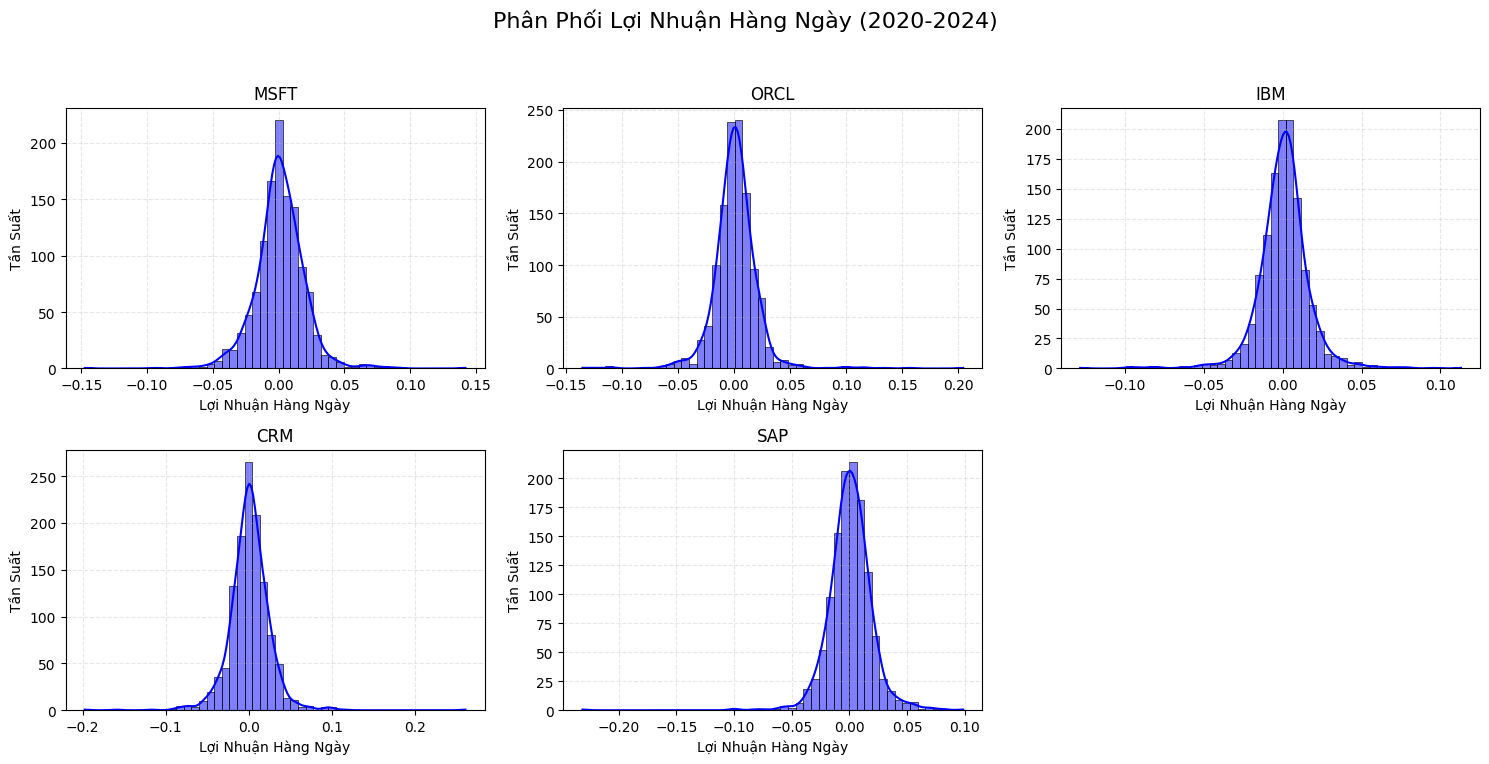

In [ ]:
# Phân Phối Lợi Nhuận Hàng Ngày
returns = {}
for ticker in tickers:
    # Đảm bảo chỉ mục ngày ở định dạng datetime
    data[ticker].index = pd.to_datetime(data[ticker].index)
    returns[ticker] = data[ticker]['Close'].pct_change()

# Lọc lợi nhuận hàng ngày cho khoảng thời gian cụ thể
daily_returns = {ticker: returns.loc['2020-01-01':'2024-11-11'] for ticker, returns in returns.items()}

# Vẽ biểu đồ phân phối lợi nhuận hàng ngày với đường cong mật độ cho năm 2024
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Phân Phối Lợi Nhuận Hàng Ngày (2020-2024)", fontsize=16)
axs = axs.flatten()
for i, ticker in enumerate(tickers):
    sns.histplot(
        daily_returns[ticker].dropna(),
        bins=50,
        kde=True,
        color="blue",
        ax=axs[i]
    )
    axs[i].set_title(ticker)
    axs[i].set_xlabel("Lợi Nhuận Hàng Ngày")
    axs[i].set_ylabel("Tần Suất")
    axs[i].grid(True, which='both', linestyle='--', alpha=0.3)
if len(tickers) < len(axs):
    fig.delaxes(axs[-1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])



#Yếu tố thời gian

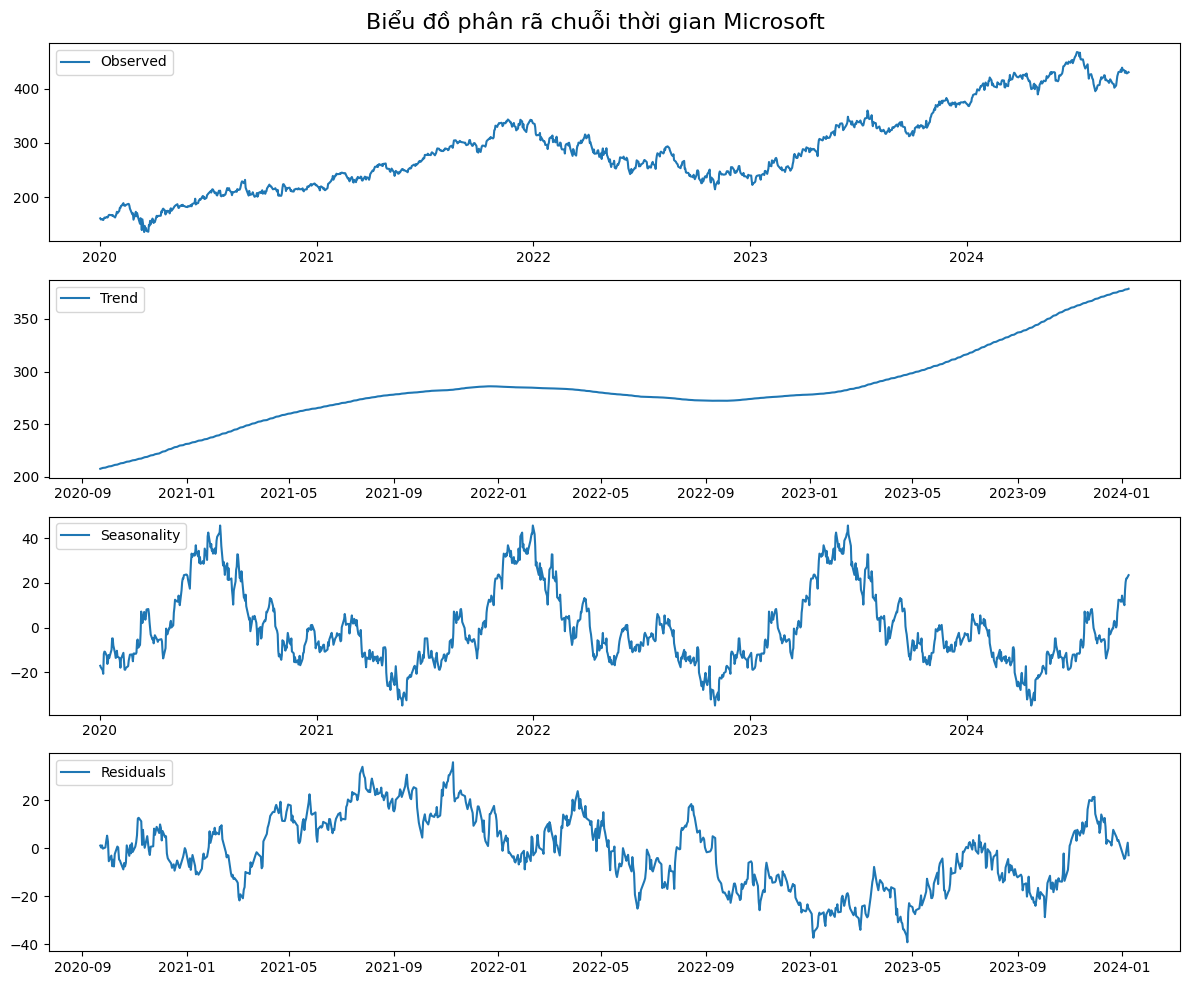

In [ ]:
# Thực hiện phân rã chuỗi thời gian
result = seasonal_decompose(microsoft_close['Close'], model='additive', period=365)
# Vẽ biểu đồ
plt.figure(figsize=(12, 10))
plt.suptitle('Biểu đồ phân rã chuỗi thời gian Microsoft', fontsize=16)
# Biểu đồ gốc (Observed)
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')
# Xu hướng (Trend)
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')
# Tính mùa vụ (Seasonality)
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonality')
plt.legend(loc='upper left')
# Phần dư (Residuals)
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

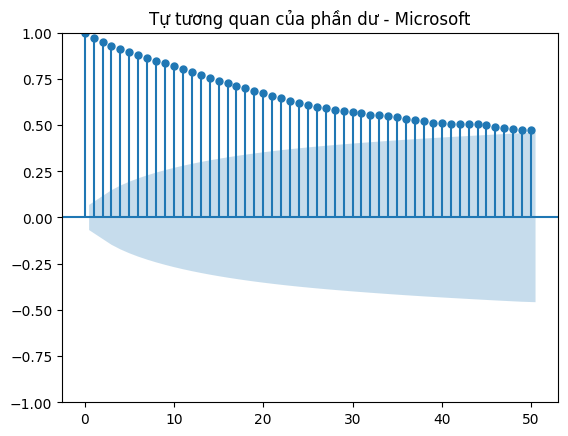

In [ ]:
# Phân tích tự tương quan của phần dư
plt.figure(figsize=(10, 5))
plot_acf(result.resid.dropna(), lags=50)
plt.title('Tự tương quan của phần dư - Microsoft')
plt.show()

#Mô hình dự báo
- Mô hình Moving Average
  - Naive
  - 3-step
  - 6-step
- Mô hình Exponentail Smoothing
  - hệ số alpha = 0.1
  - alpha tối ưu
- Mô hình Holt và Holt-Winter
  - hệ số tiêu chuẩn
  - hệ số tối ưu

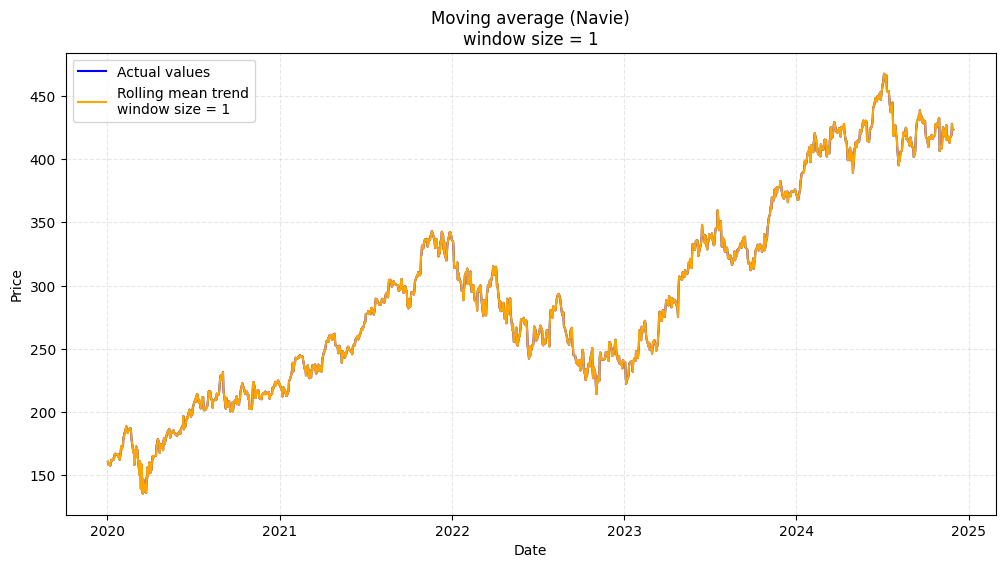

Mean Absolute Error (MAE):  0.0
Mean Squared Error (MSE):  0.0
Root Mean Squared Error (RMSE):  0.0


In [ ]:
#Mô hình Moving Average: Naive
# Tính giá trị trung bình động
window_size = 1
MA_navie = microsoft_data['Close'].rolling(window=window_size).mean()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(microsoft_data['Close'], label='Actual values', color='blue')
plt.plot(MA_navie, label=f'Rolling mean trend\nwindow size = {window_size}', color='orange')
plt.title(f'Moving average (Navie)\nwindow size = {window_size}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.show()

# Các chỉ số đo độ lệch
mae_navie = mean_absolute_error(microsoft_data['Close'], MA_navie)
mse_navie = mean_squared_error(microsoft_data['Close'], MA_navie)
rmse_navie = np.sqrt(mse_navie)
print(f"Mean Absolute Error (MAE): ", mae_navie)
print(f"Mean Squared Error (MSE): ", mse_navie)
print(f"Root Mean Squared Error (RMSE): ", rmse_navie)

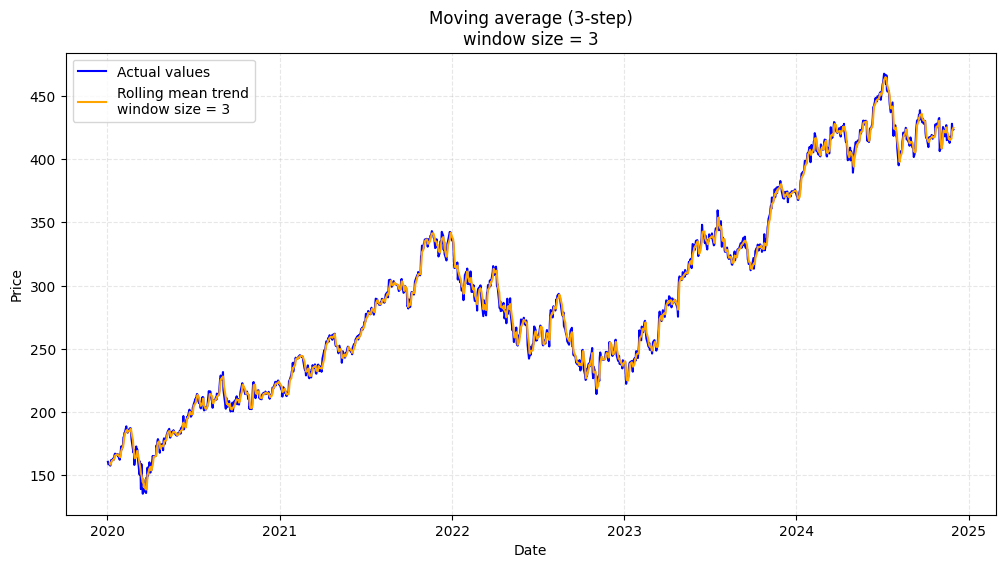

Mean Absolute Error (MAE): 2.7062050020163837
Mean Squared Error (MSE): 12.595390790680925
Root Mean Squared Error (RMSE): 3.548998561662279


In [ ]:
#Mô hình 3-step
window_size = 3
MA_3step = microsoft_data['Close'].rolling(window=window_size).mean()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(microsoft_data['Close'], label='Actual values', color='blue')
plt.plot(MA_3step, label=f'Rolling mean trend\nwindow size = {window_size}', color='orange')
plt.title(f'Moving average (3-step)\nwindow size = {window_size}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.show()
# Các chỉ số đo độ lệch
mae_3step = mean_absolute_error(microsoft_data['Close'][2:], MA_3step.dropna())
mse_3step = mean_squared_error(microsoft_data['Close'][2:], MA_3step.dropna())
rmse_3step = np.sqrt(mse_3step)
print(f"Mean Absolute Error (MAE): {mae_3step}")
print(f"Mean Squared Error (MSE): {mse_3step}")
print(f"Root Mean Squared Error (RMSE): {rmse_3step}")

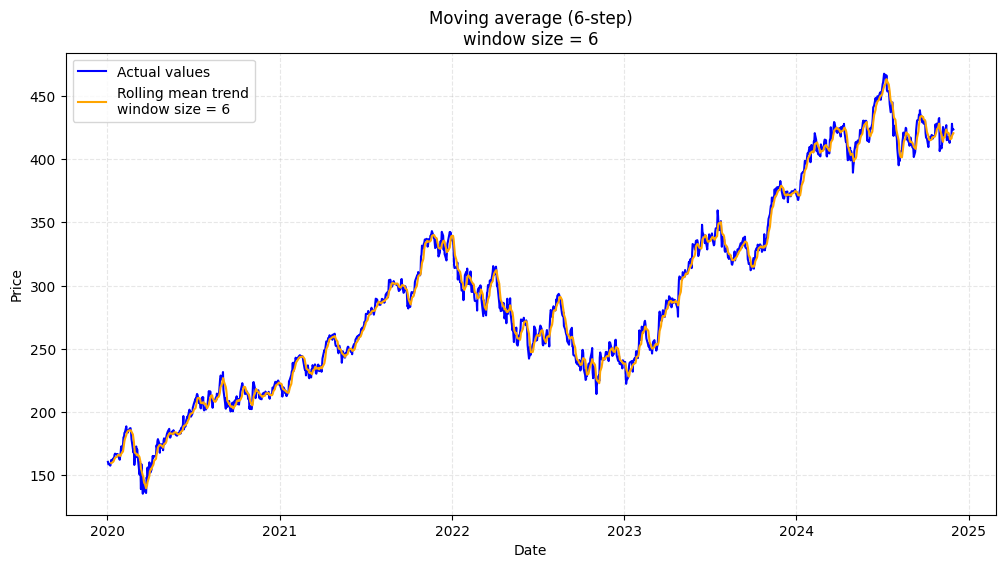

Mean Absolute Error (MAE): 4.4359457461864915
Mean Squared Error (MSE): 31.46603260432568
Root Mean Squared Error (RMSE): 5.609459207831507


In [ ]:
#Mô hình 6-step
window_size = 6
MA_6step = microsoft_data['Close'].rolling(window=window_size).mean()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(microsoft_data['Close'], label='Actual values', color='blue')
plt.plot(MA_6step, label=f'Rolling mean trend\nwindow size = {window_size}', color='orange')
plt.title(f'Moving average (6-step)\nwindow size = {window_size}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.show()
# Các chỉ số đo độ lệch
mae_6step = mean_absolute_error(microsoft_data['Close'][5:], MA_6step.dropna())
mse_6step = mean_squared_error(microsoft_data['Close'][5:], MA_6step.dropna())
rmse_6step = np.sqrt(mse_6step)
print(f"Mean Absolute Error (MAE): {mae_6step}")
print(f"Mean Squared Error (MSE): {mse_6step}")
print(f"Root Mean Squared Error (RMSE): {rmse_6step}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


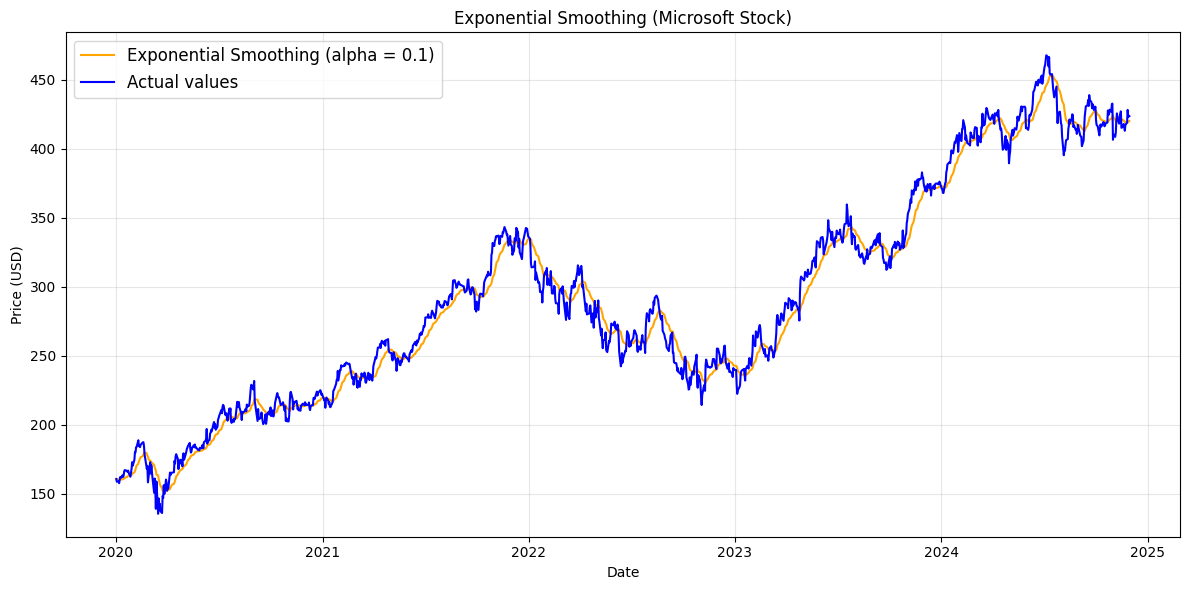

Mean Absolute Error (MAE): 8.052862798920719
Mean Squared Error (MSE): 98.49630413461736
Root Mean Squared Error (RMSE): 9.924530423884919


In [ ]:
#Mô hình Exponentail Smoothing: hệ số alpha = 0.1
alpha = 0.1
model = SimpleExpSmoothing(microsoft_data['Close']).fit(smoothing_level=alpha, optimized=False)
SES = model.fittedvalues
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(SES, label=f'Exponential Smoothing (alpha = {alpha})', color='orange')
plt.plot(microsoft_data['Close'], label='Actual values', color='blue')
plt.title('Exponential Smoothing (Microsoft Stock)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
# Các chỉ số đo độ lệch
mae_alpha01 = mean_absolute_error(microsoft_data['Close'], SES)
mse_alpha01 = mean_squared_error(microsoft_data['Close'], SES)
rmse_alpha01 = np.sqrt(mse_alpha01)
print(f"Mean Absolute Error (MAE): {mae_alpha01}")
print(f"Mean Squared Error (MSE): {mse_alpha01}")
print(f"Root Mean Squared Error (RMSE): {rmse_alpha01}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


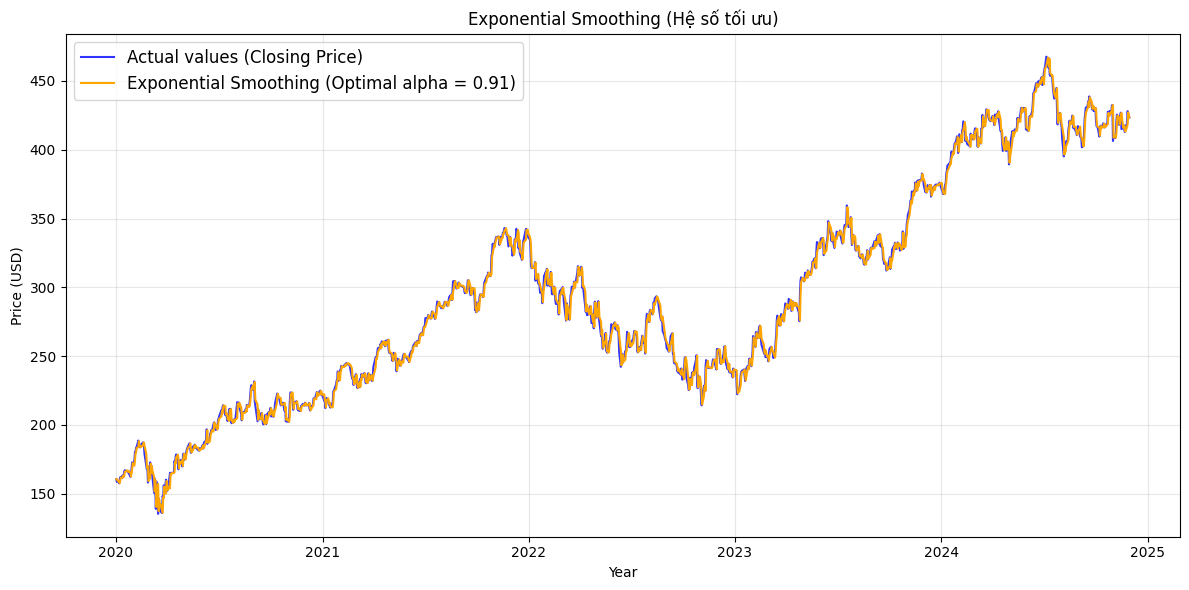

Mean Absolute Error (MAE): 3.6776228688399097
Mean Squared Error (MSE): 24.108419180366784
Root Mean Squared Error (RMSE): 4.91003250298476


In [ ]:
# Hàm tìm alpha tối ưu
def optimize_alpha(data, alpha_values):
    best_alpha = None
    best_mse = float('inf')
    for alpha in alpha_values:
        model = SimpleExpSmoothing(data).fit(smoothing_level=alpha, optimized=False)
        fitted_values = model.fittedvalues
        mse = mean_squared_error(data, fitted_values)
        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha
    return best_alpha, best_mse

# Tập giá trị alpha để thử nghiệm
alpha_range = np.linspace(0.01, 1.0, 100)
optimal_alpha, optimal_mse = optimize_alpha(microsoft_data['Close'], alpha_range)
# Áp dụng mô hình với alpha tối ưu
model = SimpleExpSmoothing(microsoft_data['Close']).fit(smoothing_level=optimal_alpha, optimized=False)
SES_opt = model.fittedvalues

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(microsoft_data['Close'], label='Actual values (Closing Price)', color='blue', alpha=0.8)
plt.plot(SES_opt, label=f'Exponential Smoothing (Optimal alpha = {optimal_alpha:.2f})', color='orange')
plt.title('Exponential Smoothing (Hệ số tối ưu)')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Các chỉ số đo độ lệch
mae_SES_opt = mean_absolute_error(microsoft_data['Close'], SES_opt)
mse_SES_opt = mean_squared_error(microsoft_data['Close'], SES_opt)
rmse_SES_opt = np.sqrt(mse_SES_opt)
print(f"Mean Absolute Error (MAE): {mae_SES_opt}")
print(f"Mean Squared Error (MSE): {mse_SES_opt}")
print(f"Root Mean Squared Error (RMSE): {rmse_SES_opt}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


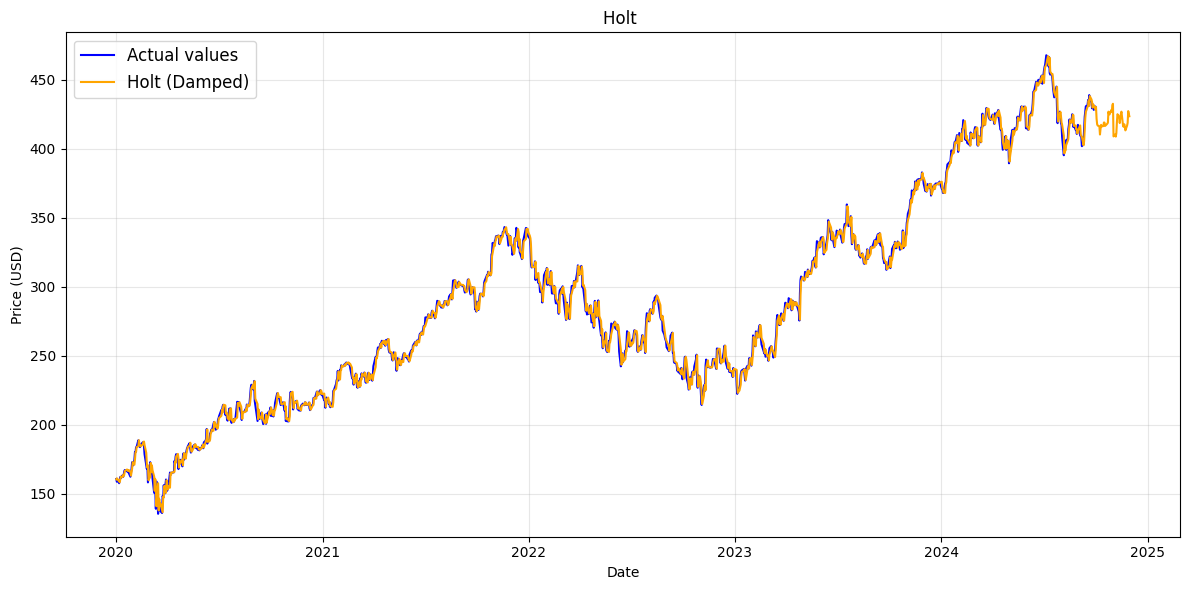

Mean Absolute Error (MAE): 3.673344635643392
Mean Squared Error (MSE): 24.08396740855207
Root Mean Squared Error (RMSE): 4.907541890656876


In [ ]:
model = ExponentialSmoothing(microsoft_data['Close'], trend='add', damped_trend=True).fit()
Holt = model.fittedvalues
# Biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(microsoft_close['Close'], label='Actual values', color='blue')
plt.plot(Holt, label=f'Holt (Damped)', color='orange')
plt.title('Holt ')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
# Các chỉ số đo độ lệch
mae_holt = mean_absolute_error(microsoft_data['Close'], Holt)
mse_holt = mean_squared_error(microsoft_data['Close'], Holt)
rmse_holt = np.sqrt(mse_holt)
print(f"Mean Absolute Error (MAE): {mae_holt}")
print(f"Mean Squared Error (MSE): {mse_holt}")
print(f"Root Mean Squared Error (RMSE): {rmse_holt}")

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignore

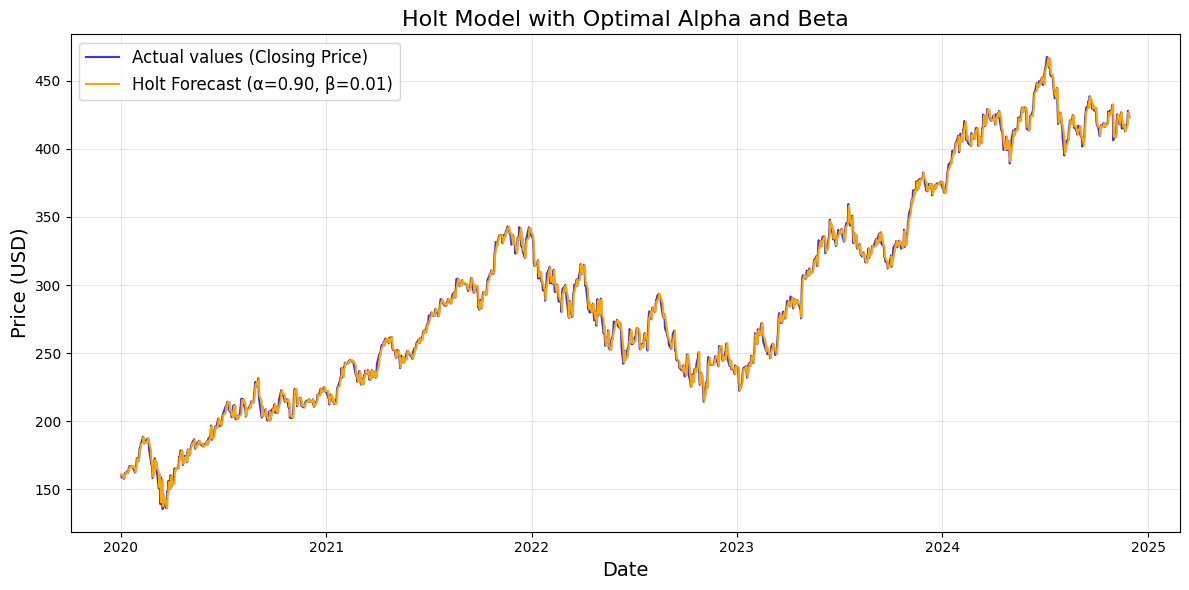

Optimal Alpha: 0.9
Optimal Beta: 0.01
Mean Absolute Error (MAE): 3.679317956712633
Mean Squared Error (MSE): 24.12077532234021
Root Mean Squared Error (RMSE): 4.9112905964054105


In [ ]:
# Hàm tìm alpha và beta tối ưu
def optimize_holt(data, alpha_values, beta_values):
    best_alpha = None
    best_beta = None
    best_mse = float('inf')

    for alpha in alpha_values:
        for beta in beta_values:
                model = ExponentialSmoothing(data, trend='add', damped_trend=True).fit(
                    smoothing_level=alpha, smoothing_trend=beta)
                fitted_values = model.fittedvalues
                mse = mean_squared_error(data, fitted_values)
                if mse < best_mse:
                    best_mse = mse
                    best_alpha = alpha
                    best_beta = beta
    return best_alpha, best_beta, best_mse

# Tập giá trị alpha và beta để thử nghiệm
alpha_range = np.linspace(0.01, 1.0, 100)
beta_range = np.linspace(0.01, 1.0, 100)

# Tìm alpha và beta tối ưu
optimal_alpha, optimal_beta, optimal_mse = optimize_holt(microsoft_data['Close'], alpha_range, beta_range)

# Áp dụng mô hình với alpha và beta tối ưu
final_model = ExponentialSmoothing(microsoft_data['Close'], trend='add', damped_trend=True).fit(
    smoothing_level=optimal_alpha, smoothing_trend=optimal_beta)
Holt_opt = final_model.fittedvalues

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(microsoft_data['Close'], label='Actual values (Closing Price)', color='blue', alpha=0.8)
plt.plot(Holt_opt, label=f'Holt Forecast (α={optimal_alpha:.2f}, β={optimal_beta:.2f})', color='orange')
plt.title('Holt Model with Optimal Alpha and Beta', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Tính các chỉ số đo lường lỗi
mae_holt_opt = mean_absolute_error(microsoft_data['Close'], Holt_opt)
mse_holt_opt = mean_squared_error(microsoft_data['Close'], Holt_opt)
rmse_holt_opt = np.sqrt(mse_holt_opt)

print(f"Optimal Alpha: {optimal_alpha}")
print(f"Optimal Beta: {optimal_beta}")
print(f"Mean Absolute Error (MAE): {mae_holt_opt}")
print(f"Mean Squared Error (MSE): {mse_holt_opt}")
print(f"Root Mean Squared Error (RMSE): {rmse_holt_opt}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


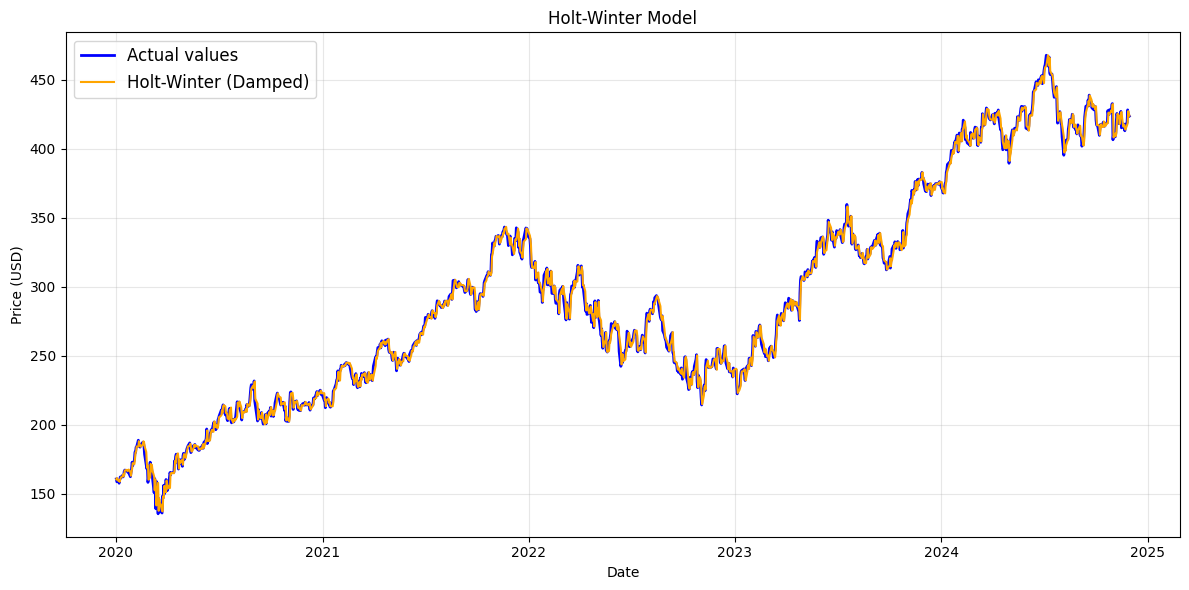

Mean Absolute Error (MAE): 3.6446795973443606
Mean Squared Error (MSE): 23.906544659215907
Root Mean Squared Error (RMSE): 4.889431936249435


In [ ]:
# Mô hình Holt-Winter: hệ số chuẩn
model = ExponentialSmoothing(
    microsoft_data['Close'],
    seasonal='add',
    seasonal_periods=7,
    trend='add',
    damped_trend=True
).fit()

Holt_winter = model.fittedvalues

# Biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(microsoft_data['Close'], label='Actual values', color='blue', linewidth=2)
plt.plot(Holt_winter, label=f'Holt-Winter (Damped)', color='orange')
plt.title('Holt-Winter Model')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Các chỉ số đo độ lệch
mae_holt_winter = mean_absolute_error(microsoft_data['Close'], Holt_winter)
mse_holt_winter = mean_squared_error(microsoft_data['Close'], Holt_winter)
rmse_holt_winter = np.sqrt(mse_holt_winter)

# In kết quả
print(f"Mean Absolute Error (MAE): {mae_holt_winter}")
print(f"Mean Squared Error (MSE): {mse_holt_winter}")
print(f"Root Mean Squared Error (RMSE): {rmse_holt_winter}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


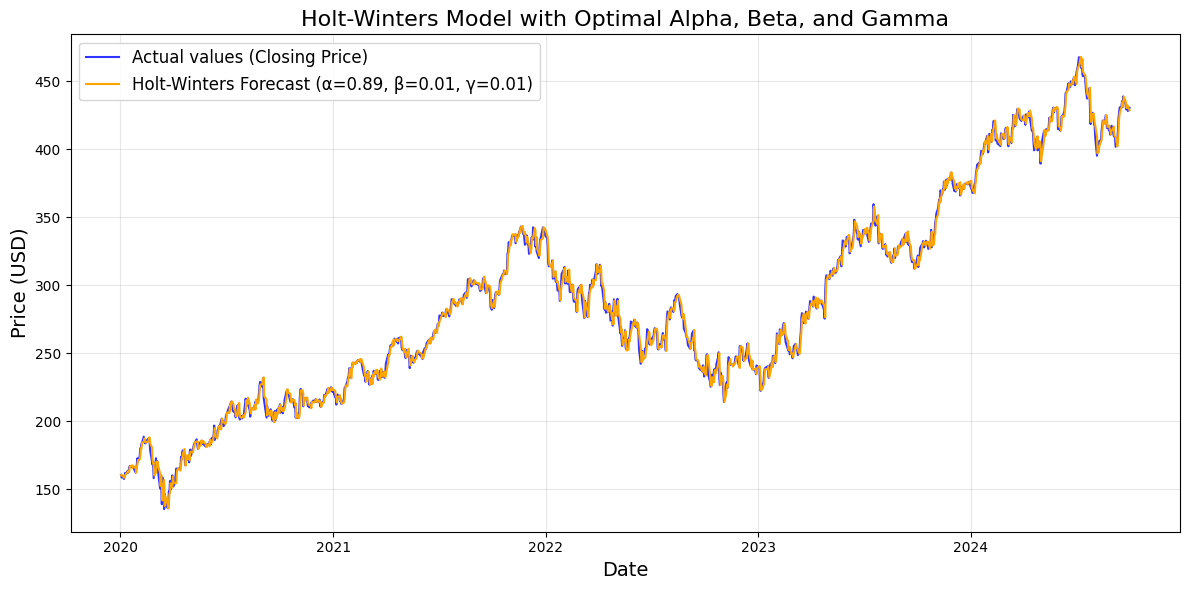

Optimal Alpha: 0.89
Optimal Beta: 0.01
Optimal Gamma: 0.01
Mean Absolute Error (MAE): 3.6797836892035924
Mean Squared Error (MSE): 23.75391801079199
Root Mean Squared Error (RMSE): 4.8737991352529075


In [ ]:
#Mô hình Holt-Winter: hệ số tối ưu
# Hàm tìm alpha, beta, gamma tối ưu
def optimize_holt_winters(data, alpha_values, beta_values, gamma_values, seasonal_periods):
    best_alpha = None
    best_beta = None
    best_gamma = None
    best_mse = float('inf')

    for alpha in alpha_values:
        for beta in beta_values:
            for gamma in gamma_values:
                try:
                    model = ExponentialSmoothing(
                        data,
                        trend='add',
                        seasonal='add',
                        seasonal_periods=seasonal_periods
                    ).fit(
                        smoothing_level=alpha,
                        smoothing_trend=beta,
                        smoothing_seasonal=gamma
                    )
                    fitted_values = model.fittedvalues
                    mse = mean_squared_error(data, fitted_values)
                    if mse < best_mse:
                        best_mse = mse
                        best_alpha = alpha
                        best_beta = beta
                        best_gamma = gamma
                except Exception as e:
                    # Bỏ qua các trường hợp không hợp lệ
                    pass

    return best_alpha, best_beta, best_gamma, best_mse

# Tập giá trị alpha, beta, gamma để thử nghiệm
alpha_range = np.linspace(0.01, 1.0, 10)
beta_range = np.linspace(0.01, 1.0, 10)
gamma_range = np.linspace(0.01, 1.0, 10)

# Tìm alpha, beta, gamma tối ưu
optimal_alpha, optimal_beta, optimal_gamma, optimal_mse = optimize_holt_winters(
    microsoft_close['Close'],
    alpha_range,
    beta_range,
    gamma_range,
    seasonal_periods=7
)

# Áp dụng mô hình với alpha, beta, gamma tối ưu
final_model = ExponentialSmoothing(
    microsoft_close['Close'],
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit(
    smoothing_level=optimal_alpha,
    smoothing_trend=optimal_beta,
    smoothing_seasonal=optimal_gamma
)
Holt_Winters_opt = final_model.fittedvalues

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(microsoft_close['Close'], label='Actual values (Closing Price)', color='blue', alpha=0.8)
plt.plot(Holt_Winters_opt, label=f'Holt-Winters Forecast (α={optimal_alpha:.2f}, β={optimal_beta:.2f}, γ={optimal_gamma:.2f})', color='orange')
plt.title('Holt-Winters Model with Optimal Alpha, Beta, and Gamma', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Tính các chỉ số đo lường lỗi
mae_holt_winter_opt = mean_absolute_error(microsoft_close['Close'], Holt_Winters_opt)
mse_holt_winter_opt = mean_squared_error(microsoft_close['Close'], Holt_Winters_opt)
rmse_holt_winter_opt = np.sqrt(mse_holt_winter_opt)

print(f"Optimal Alpha: {optimal_alpha}")
print(f"Optimal Beta: {optimal_beta}")
print(f"Optimal Gamma: {optimal_gamma}")
print(f"Mean Absolute Error (MAE): {mae_holt_winter_opt}")
print(f"Mean Squared Error (MSE): {mse_holt_winter_opt}")
print(f"Root Mean Squared Error (RMSE): {rmse_holt_winter_opt}")


In [ ]:
models = ['MA_navie', 'MA_3step', 'MA_6step', 'SES', 'SES_opt', 'Holt', 'Holt_opt', 'Holt_winter', 'Holt_Winters_opt']
mae_scores = [mae_navie, mae_3step, mae_6step, mae_alpha01, mae_SES_opt, mae_holt, mae_holt_opt, mae_holt_winter, mae_holt_winter_opt]
mse_scores = [mse_navie, mse_3step, mse_6step, mse_alpha01, mse_SES_opt, mse_holt, mse_holt_opt, mse_holt_winter, mse_holt_winter_opt]
mape_scores = [rmse_navie, rmse_3step, rmse_6step, rmse_alpha01, rmse_SES_opt, rmse_holt, rmse_holt_opt, rmse_holt_winter, rmse_holt_winter_opt]


# Tạo bảng thống kê các chỉ số
evaluation = pd.DataFrame({'Model': models, 'MSE': mse_scores, 'MAE': mae_scores, 'MAPE': mape_scores})
evaluation.set_index('Model', inplace=True)
evaluation

,MSE,MAE,MAPE
Model,,,
MA_navie,0.000000,0.000000,0.000000
MA_3step,12.595391,2.706205,3.548999
MA_6step,31.466033,4.435946,5.609459
SES,98.496304,8.052863,9.924530
SES_opt,24.108419,3.677623,4.910033
Holt,24.083967,3.673345,4.907542
Holt_opt,24.120775,3.679318,4.911291
Holt_winter,23.906545,3.644680,4.889432
Holt_Winters_opt,23.753918,3.679784,4.873799
